In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm
from matplotlib import pyplot as plt

# A few test imports that aren't needed
#from fredget import fredget
# df_m = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv',parse_dates=True, index_col=1)
# df_q = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/quarterly/current.csv',parse_dates=True, index_col=1)
# df_m.to_csv('tester.csv')


In [2]:
def transform(column, transforms,dfreq):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if dfreq == 'Q' else 1

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column


In [3]:
def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # # 3. Extract the date as an index
    # orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    # orig_m.drop('sasdate', axis=1, inplace=True)
    orig_m['sasdate'] = pd.to_datetime(orig_m['sasdate'],format='%m/%d/%Y')
    orig_m.set_index('sasdate',inplace=True)
    #orig_m.drop('sasdate', axis=1, inplace=True)
   

    #4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m,dfreq ='M')

  

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    # orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    # orig_q.drop('sasdate', axis=1, inplace=True)
    orig_q['sasdate'] = pd.to_datetime(orig_q['sasdate'],format='%m/%d/%Y')
    orig_q.set_index('sasdate',inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q,dfreq ='Q')


    # - Output datasets ------------------------------------------------------
    return dta_m,dta_q

In [16]:
#Decide whether to recollect the data 
pull_data = 0
if pull_data:
    df_m,df_q = load_fredmd_data('2023-02')
    df_m.to_csv('temp/df.csv')
    df_q.to_csv('temp/df_q.csv')
else:
    df_m = pd.read_csv('temp/df.csv')
    df_q = pd.read_csv('temp/df_q.csv')
    
df_m.set_index('sasdate',inplace=True)
df_q.set_index('sasdate',inplace=True)

#Merge on the quarterly data?
df = pd.merge(df_m, df_q, left_index=True, right_index=True,how='left')
df.head()
#Add the QGDP as the target
df['GDPC1_continuous']= df['GDPC1'].fillna(method="bfill")


In [17]:
import math 
glob_list = list(df.columns.values)
reglist = list()

df_reg = df.copy()
target = 'GDPC1_continuous'

for f in glob_list:
    for i in range(1,10):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        df_reg[varname] = df_reg[f].shift(i) 


df_model = df_reg.loc['1980-1-1':'2016-1-1']

x = df_model[reglist]
y = df_model[target]
#print(reglist)

'''XGBOOST BEGINS HERE'''
regressor = xgb.XGBRegressor(
    n_estimators=50,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)
regressor.fit(x, y)

/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_11765/2872727846.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_reg[varname] = df_reg[f].shift(i)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_11765/2872727846.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_reg[varname] = df_reg[f].shift(i)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_11765/2872727846.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

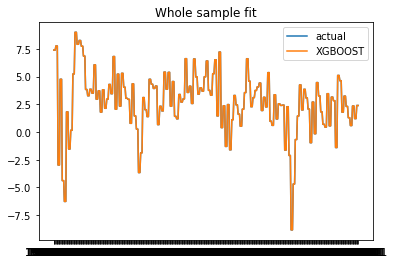

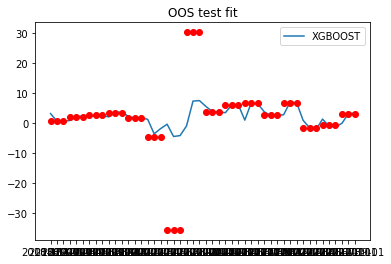

In [22]:
xgpred = regressor.predict(x)
xg_df = pd.DataFrame(xgpred, columns = ['xgfit'], index = df_model.index)

plt.plot(y,label="actual")
plt.plot(xg_df['xgfit'],label="XGBOOST")
plt.legend()
plt.title('Whole sample fit')

df_test = df_reg.loc['2018-1-1':'2022-1-1']
y_test = df_test[target]
x_test = df_test[reglist]

xgpred_test = regressor.predict(x_test)
xg_df_test = pd.DataFrame(xgpred_test, columns = ['xgfit'], index = df_test.index)

plt.figure()
#plt.plot(y_test,label="actual")
plt.plot(xg_df_test,label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test[target], 'ro')

In [13]:
#df.to_csv('tester.csv')